In [ ]:
!git clone https://github.com/Janspiry/Palette-Image-to-Image-Diffusion-Models

In [1]:
import os
os.chdir('Palette-Image-to-Image-Diffusion-Models')
os.getcwd()

'/workspace/Palette-Image-to-Image-Diffusion-Models'

In [2]:
%cd config

/workspace/Palette-Image-to-Image-Diffusion-Models/config


In [ ]:
!pip install -r requirements.txt
!pip install gdown
!gdown --id 12IOylNPjOvdMGfIvTEKD5G-aWIycSGW7

In [5]:
%%writefile inpainting_celebahq.patch
--- a/config/inpainting_celebahq.json
+++ b/config/inpainting_celebahq.json
@@ -10,7 +10,7 @@
         "tb_logger": "tb_logger", // path of tensorboard logger
         "results": "results",
         "checkpoint": "checkpoint",
-        "resume_state": "experiments/train_inpainting_celebahq_220426_233652/checkpoint/190" 
+        "resume_state": "200" 
         // "resume_state": null // ex: 100, loading .state  and .pth from given epoch and iteration
     },
 
@@ -48,7 +48,7 @@
             "which_dataset": {
                 "name": "InpaintDataset", // import Dataset() class / function(not recommend) from default file
                 "args":{
-                    "data_root": "datasets/celebahq/flist/test.flist",
+                    "data_root": "input",
                     "mask_config": {
                         "mask_mode": "center"
                     }
@@ -56,8 +56,8 @@
             },
             "dataloader":{
                 "args":{
-                    "batch_size": 8,
-                    "num_workers": 4,
+                    "batch_size": 1,
+                    "num_workers": 1,
                     "pin_memory": true
                 }
             }
--

Writing inpainting_celebahq.patch


In [6]:
!apt-get install dos2unix
!dos2unix inpainting_celebahq.json
!patch < inpainting_celebahq.patch

Reading package lists... Done
Building dependency tree       
Reading state information... Done
dos2unix is already the newest version (7.4.0-2).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
dos2unix: converting file inpainting_celebahq.json to Unix format...
patching file inpainting_celebahq.json
Reversed (or previously applied) patch detected!  Assume -R? [n] ^C


In [ ]:
!pip install kaggle
!kaggle datasets download -d badasstechie/celebahq-resized-256x256
!pip install Pillow==9.5.0
## better run in terminal: apt-get update && apt-get install ffmpeg libsm6 libxext6  -y

In [17]:
%cd ..

/workspace/Palette-Image-to-Image-Diffusion-Models


In [160]:
!python run.py -c config/inpainting_celebahq.json -p test

export CUDA_VISIBLE_DEVICES=1
run.py:28: UserWarning: You have chosen to use cudnn for accleration. torch.backends.cudnn.enabled=True
  warnings.warn('You have chosen to use cudnn for accleration. torch.backends.cudnn.enabled=True')
  5%|█▊                                       | 9/197 [04:50<1:41:07, 32.28s/it]
Close the Tensorboard SummaryWriter.
Traceback (most recent call last):
  File "run.py", line 92, in <module>
    main_worker(0, 1, opt)
  File "run.py", line 60, in main_worker
    model.test()
  File "/workspace/Palette-Image-to-Image-Diffusion-Models/models/model.py", line 178, in test
    self.output, self.visuals = self.netG.restoration(self.cond_image, y_t=self.cond_image, 
  File "/root/miniconda3/lib/python3.8/site-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/workspace/Palette-Image-to-Image-Diffusion-Models/models/network.py", line 98, in restoration
    y_t = self.p_sample(y_t, t, y_cond=y_cond)
  File "

In [121]:
!python run.py -p train -c config/inpainting_celebahq.json

export CUDA_VISIBLE_DEVICES=1
run.py:28: UserWarning: You have chosen to use cudnn for accleration. torch.backends.cudnn.enabled=True
  warnings.warn('You have chosen to use cudnn for accleration. torch.backends.cudnn.enabled=True')
  5%|██                                          | 3/65 [00:01<00:31,  1.95it/s]
Close the Tensorboard SummaryWriter.
Traceback (most recent call last):
  File "run.py", line 92, in <module>
    main_worker(0, 1, opt)
  File "run.py", line 58, in main_worker
    model.train()
  File "/workspace/Palette-Image-to-Image-Diffusion-Models/core/base_model.py", line 45, in train
    train_log = self.train_step()
  File "/workspace/Palette-Image-to-Image-Diffusion-Models/models/model.py", line 111, in train_step
    loss.backward()
  File "/root/miniconda3/lib/python3.8/site-packages/torch/_tensor.py", line 396, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/root/miniconda3/lib/python3.8/site-packages/tor

In [71]:
opt['datasets']['train']['which_dataset']['args']['data_root']

'datasets/celebahq/flist/train.flist'

## Visualization

In [136]:
from PIL import Image

In [161]:
test_dir = "experiments/test_inpainting_celebahq_240227_134703/results/test/0"

In [131]:
def sort_files(files):
    return sorted(files, key = lambda path: int(path[re.search(r"\d+", path).start() : re.search(r"\d+", path).end()]))

In [162]:
files = os.listdir(test_dir)

origs = sort_files([file for file in files if 'GT' in file])
masks = sort_files([file for file in files if 'Mask' in file])
gens =  sort_files([file for file in files if 'Out' in file])

In [143]:
total_h = 256 * len(origs)
total_w = 256 * 3

In [151]:
new_image = Image.new('RGB', (total_w, total_h), 'white')

In [163]:
triple_images = []
h_offset = 0
for orig, mask, gen in zip(origs, masks, gens):
    new_image = Image.new('RGB', (256 * 3, 256), 'white')
    new_image.paste(Image.open(os.path.join(test_dir, orig)), (0, 0))
    new_image.paste(Image.open(os.path.join(test_dir, mask)), (256, 0))
    new_image.paste(Image.open(os.path.join(test_dir, gen)),  (256*2, 0))
    triple_images.append(new_image)

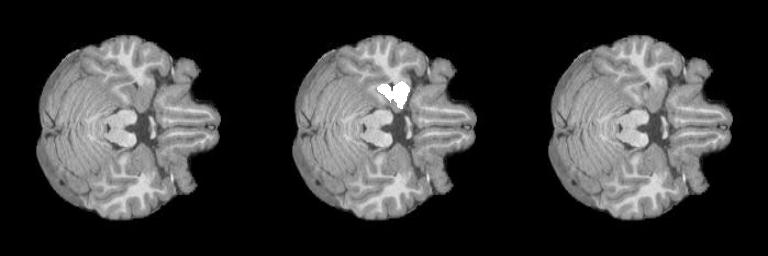

In [164]:
triple_images[0]

In [165]:
!mkdir generation_comparisons_real-masks

In [166]:
for i in range (len(triple_images)):
    triple_images[i].save(f'generation_comparisons_real-masks/orig-mask-gen-{i}.jpeg')

In [154]:
new_image.save('palette-comparison.jpeg')